In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter

In [3]:
df=pd.read_csv('preprocessed reviews dataset.csv')

In [4]:
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [7]:
df.dropna(inplace=True)

In [8]:
# adding a new column to get length of the review string
df['length'] = df['text_'].apply(len)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40431 non-null  object 
 1   rating    40431 non-null  float64
 2   label     40431 non-null  object 
 3   text_     40431 non-null  object 
 4   length    40431 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [10]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                 
             mean         std   min   25%    50%    75%     max  
label                                                            
CG     173.267722  173.614884  13.0  57.0   99.0  216.0  1300.0  
OR     237.060200  251.930537   8.0  74.0  134.0  295.0  2224.0

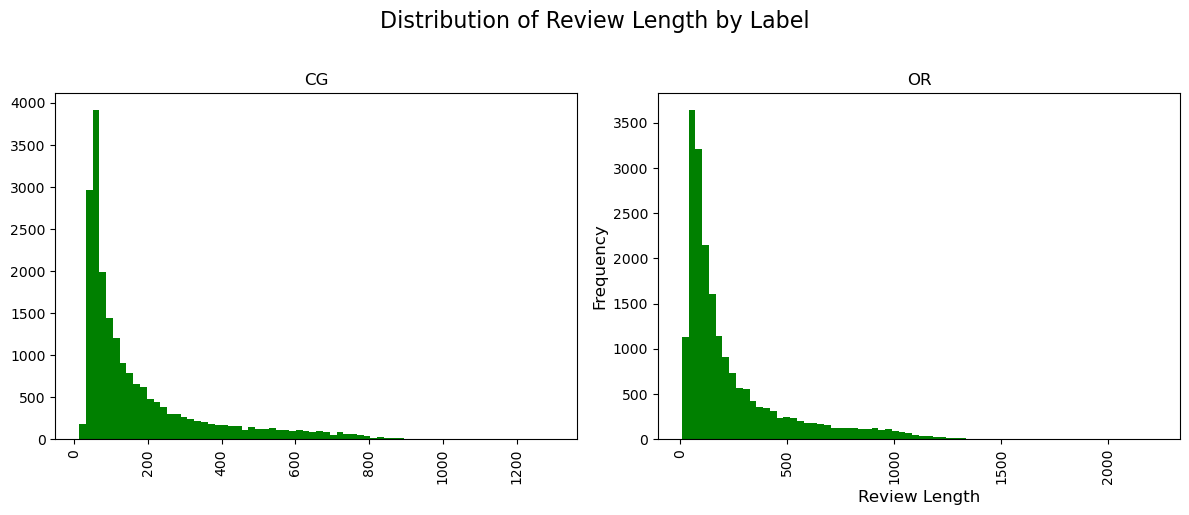

In [11]:
df.hist(column='length',by='label', bins=70,color='green',figsize=(12,5))
plt.suptitle("Distribution of Review Length by Label", y=1.02, fontsize=16)
plt.xlabel("Review Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Correlation analysis between numerical columns (rating and length)
correlation_matrix = df[['rating', 'length']].corr()

# Category-specific analysis: Average review length and proportion of labels by category
category_analysis = df.groupby('category').agg(
    avg_length=('length', 'mean'),
    total_reviews=('label', 'count'),
    genuine_proportion=('label', lambda x: (x == 'CG').mean())  # Assuming 'CG' indicates genuine
).sort_values(by='total_reviews', ascending=False)

# Display the correlation matrix and category-specific summary
correlation_matrix, category_analysis.head()


(          rating    length
 rating  1.000000 -0.074546
 length -0.074546  1.000000,
                     avg_length  total_reviews  genuine_proportion
 category                                                         
 Kindle_Store_5      248.722199           4730                 0.5
 Books_5             253.916705           4370                 0.5
 Pet_Supplies_5      177.941232           4254                 0.5
 Home_and_Kitchen_5  181.374507           4056                 0.5
 Electronics_5       209.278335           3988                 0.5)

In [13]:
# describing the largest review
#df['label']=='OR' filters the DataFrame by the label 'OR'.
#.sort_values(by='length', ascending=False) sorts the data by text length.
#.head() retrieves the top 5 longest texts.
#.iloc[0] gets the first row (longest text).
#.text_ extracts the text_ column (the actual text).

df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

"weak on current scienc after see twice i agr much posit five star review out respect read review i 'll repeat everyth i like present i found goofi over ear hairdo facial hair arrang daniel vitali describ `` wild food expert `` distract ugh ditto david wolf extrem goofi wild hairdo on hand jon gabriel describ `` author weight loss expert `` nice groom good present hi stori person transform fellow pound whew becom jock normal weight inspir christian northrup preserv rank one america 's cutest doctor a realli nice look woman present dr. mercola jason vale kri carr alejandro junger fine it disappoint jami oliv popular uk give babi cow growth fluid pas unscientif popular idea milk none present anyth zilch say work doctor t. colin campbel milk bodi bad it good see present take stand sugar they agr evil sugar refin carbohydr with respect dr. northrup `` it 's fat make fat 's sugar `` statement pas muster commun expert recogn evil sugar not mutual exclu recogn proven danger fat particularli f

In [14]:
df.length.describe()

count    40431.000000
mean       205.164750
std        218.682902
min          8.000000
25%         64.000000
50%        116.000000
75%        253.000000
max       2224.000000
Name: length, dtype: float64

In [15]:
# filtering out important words in the review
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x0000022DC1354C20>)

In [17]:
# text is represented as a collection of word counts
# It converts a collection of text documents into a matrix of token counts, where each row represents a document and each column represents a unique word (or token)

In [18]:
# analyzer=text_process= allows to clean and tokenize the text before converting it into a document-term matrix for further analysis or machine learning tasks

In [ ]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [ ]:
# bow_transformer then creates a vocabulary dictionary where the keys are the unique words, and the values are their corresponding indices in the feature space.
# bow_transformer.vocabulary is a dictionary that holds the vocabulary that CountVectorizer learned after calling fit().
# Each unique word (token) in the corpus (the text data) is assigned a unique index
#len(bow_transformer.vocabulary_):returns the size of the vocabulary, i.e., the number of unique terms (words) that the vectorizer learned from the text.

In [ ]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

In [ ]:
# example review
review5= df['text_'][4]
review5

In [ ]:
bow_msg5 = bow_transformer.transform([review5])
print(bow_msg5)
print(bow_msg5.shape)

In [ ]:
# (0, 13271) represents that at index 13271 in the vocabulary build, the word occurs once in the review.

In [ ]:
# bow_msg5.shape:The shape of the matrix bow_msg4 is (1, n_features). The 1 represents the single review (since we passed one review to transform()).
# n_features is the number of features in the vocabulary (the total unique words), which is the same as the number of unique words in the vocabulary learned by the CountVectorizer

In [ ]:
#  (1, 34202) indicates that the sparse matrix has 1 row (for the single review) and 34,452 columns (representing the total vocabulary size).

In [ ]:
# lets see the unique words

In [ ]:
print(bow_transformer.get_feature_names_out()[19942])
print(bow_transformer.get_feature_names_out()[26772])

In [ ]:
bow_reviews = bow_transformer.transform(df['text_'])

In [ ]:
#shape: This provides insight into the size of your feature matrix. In this case, it's the number of reviews and the number of unique words.
# nnz: tells you about the sparsity of your matrix. A high value of nnz compared to the total size (shape[0] * shape[1]) indicates a relatively dense matrix, while a low value of nnz indicates that the matrix is sparse, meaning that most of the words are not present in most of the reviews.

In [ ]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

In [ ]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

In [ ]:
# t 7% of the matrix is occupied by non-zero elements (or 93% is zeros, making it a sparse matrix)

In [ ]:
# transform(bow_reviews) converts the bow_reviews matrix from simple counts to TF-IDF (Term Frequency-Inverse Document Frequency) values.
# TF-IDF scores indicate the importance of a word in a document relative to its occurrence across the entire corpus.
#Higher values mean a word is more unique to a particular document.

tfidf_transformer = TfidfTransformer().fit(bow_reviews)

tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

In [ ]:
tfidf_reviews

In [ ]:
tfidf_transformer

**creating and training the datasets**

In [ ]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

**Decision Tree**

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [ ]:
X= df['text_']
Y= df['label']
review_train, review_test, label_train, label_test = train_test_split(X,Y,test_size=0.35)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
from sklearn.pipeline import Pipeline
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [ ]:
pipeline.fit(review_train,label_train)

In [ ]:
dtree_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=6, max_depth=6)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [ ]:
pipeline.fit(review_train,label_train)
dtree_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

In [ ]:
# classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
# pipeline = Pipeline([
#     ('bow',CountVectorizer(analyzer=text_process)),
#     ('tfidf',TfidfTransformer()),
#     ('classifier',DecisionTreeClassifier())
# ])

In [ ]:
# classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
# pipeline = Pipeline([
#     ('bow',CountVectorizer(analyzer=text_process)),
#     ('tfidf',TfidfTransformer()),
#     ('classifier',classifier)
# ])

In [ ]:
# pipeline.fit(review_train,label_train)
# dtree_pred = pipeline.predict(review_test)
# print('Classification Report:',classification_report(label_test,dtree_pred))
# print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
# print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
# print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

**Random Forest**

**Naive Bayes**

In [ ]:
from sklearn.utils.sparsefuncs import mean_variance_axis
import numpy as np
from sklearn import datasets
class NaiveBayes:

    def fit(self, X, y): 
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            mean, var = mean_variance_axis(X_c, axis=0)  # Compute mean and variance for sparse data
            self._mean[idx, :] = mean
            self._var[idx, :] = var
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
    
    # Ensure x is dense and 1D
        if hasattr(x, "toarray"):  # Check if x is sparse
            x = x.toarray().flatten()
        else:
            x = np.asarray(x).flatten()  # Ensure x is a 1D numpy array
    
    # Perform element-wise Gaussian PDF computation
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator


        print(f"x shape: {x.shape}, mean shape: {mean.shape}, var shape: {var.shape}")

In [ ]:
# # Testing
# if __name__ == "__main__":
#     # Imports
#     from sklearn.model_selection import train_test_split
#     from sklearn import datasets

#     def accuracy(y_true, y_pred):
#         accuracy = np.sum(y_true == y_pred) / len(y_true)
#         return accuracy

#     X, y = datasets.make_classification(
#         n_samples=1000, n_features=10, n_classes=2, random_state=123
#     )
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=123
#     )

#     nb = NaiveBayes()
#     nb.fit(X_train, y_train)
#     predictions = nb.predict(X_test)

#     print("Naive Bayes classification accuracy", accuracy(y_test, predictions))

In [ ]:
# X, y = datasets.make_classification(
#         n_samples=1000, n_features=10, n_classes=2, random_state=123
#     )

In [ ]:
X= df['text_']
y= df['label']
review_train, review_test, label_train, label_test = train_test_split(X,y,test_size=0.35,random_state=123)

In [ ]:
classifier = NaiveBayes()
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process,max_features=10000)),
    ('tfidf',TfidfTransformer()),
    ('classifier',NaiveBayes())
])

In [ ]:
pipeline.fit(review_train,label_train)
naive_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,naive_pred))
print('Confusion Matrix:',confusion_matrix(label_test,naive_pred))
print('Accuracy Score:',accuracy_score(label_test,naive_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,naive_pred)*100,2)) + '%')

In [ ]:
classifier = NaiveBayes()
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',classifier)
])

In [ ]:
pipeline.fit(review_train,label_train)
naive_pred = pipeline.predict(review_test)
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,naive_pred)*100,2)) + '%')

**K-NN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=2))
])
pipeline.fit(review_train,label_train)
knn_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,knn_pred))
print('Confusion Matrix:',confusion_matrix(label_test,knn_pred))
print('Accuracy Score:',accuracy_score(label_test,knn_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')

**SVM**

In [ ]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])
pipeline.fit(review_train,label_train)
svc_pred = pipeline.predict(review_test)
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')